In [ ]:
# Project 4: Medical Insurance Cost Prediction

In [1]:
# Importing necessary libraries

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold,train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import mean_squared_error, explained_variance_score
from math import sqrt
import re

In [2]:
df=pd.read_csv('insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
df.isnull().any()

age         False
sex         False
bmi         False
children    False
smoker      False
region      False
charges     False
dtype: bool

In [5]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [6]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [8]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
1333    False
1334    False
1335    False
1336    False
1337    False
Length: 1338, dtype: bool

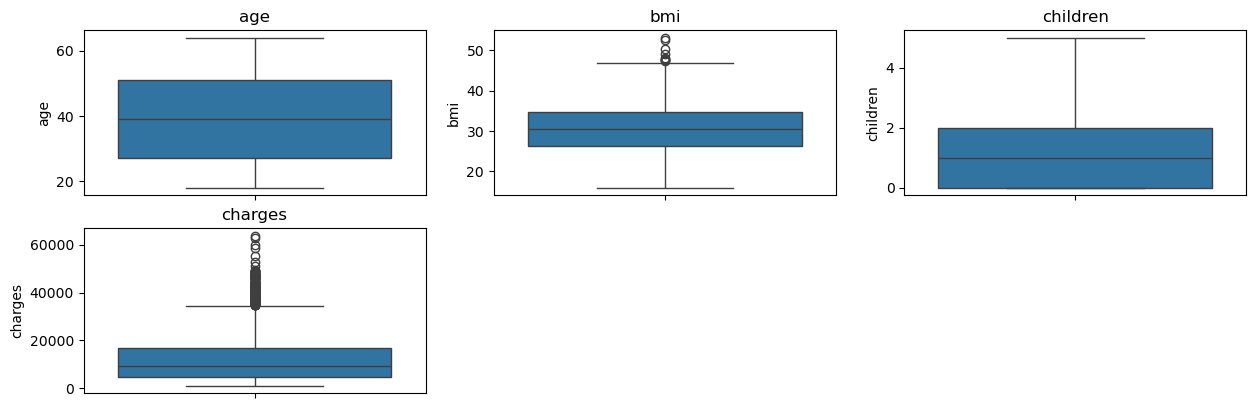

In [9]:
# to check outliers in numerical columns using boxplot

plt.figure(figsize=(15,15))
Numericals=['age', 'bmi', 'children','charges']
plot=1
for i in Numericals:
    plt.subplot(6,3,plot)
    sns.boxplot(df[i])
    plt.title(i)
    plot+=1

In [10]:
# to remove outliers using IQR method

Numericals=['age', 'bmi', 'children','charges']
for i in Numericals:
    flag=True
    while(flag):
        q25,q75=np.percentile(df[i],[25,75])
        IQR=q75-q25
        lower_limit=q25-1.5*IQR
        upper_limit=q75+1.5*IQR
        if(df[i]<lower_limit).sum() or (df[i]>upper_limit).sum():
            df[i]=np.where(df[i]>upper_limit,upper_limit,df[i])
            df[i]=np.where(df[i]<lower_limit,upper_limit,df[i])
            flag=True
        else:
            flag=False

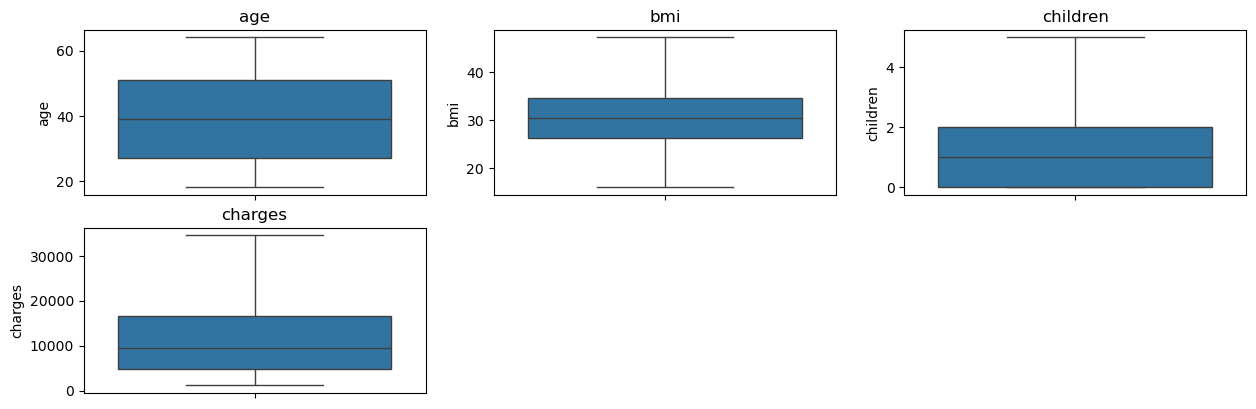

In [11]:
# to check outliers in numerical columns using boxplot

plt.figure(figsize=(15,15))
Numericals=['age', 'bmi', 'children','charges']
plot=1
for i in Numericals:
    plt.subplot(6,3,plot)
    sns.boxplot(df[i])
    plt.title(i)
    plot+=1

In [12]:
# to convert categorical columns into numerical columns 

le=LabelEncoder()
categorical=['sex','smoker','region']
for i in categorical:
    df[i]=le.fit_transform(df[i])

In [13]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1,10600.54830
1334,18,0,31.920,0,0,0,2205.98080
1335,18,0,36.850,0,0,2,1629.83350
1336,21,0,25.800,0,0,3,2007.94500


In [14]:
# Split-Dependent and Independent Variables

x=df.drop(['charges'],axis=1)
x

,age,sex,bmi,children,smoker,region
0,19,0,27.900,0,1,3
1,18,1,33.770,1,0,2
2,28,1,33.000,3,0,2
3,33,1,22.705,0,0,1
4,32,1,28.880,0,0,1
...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1
1334,18,0,31.920,0,0,0
1335,18,0,36.850,0,0,2
1336,21,0,25.800,0,0,3


In [15]:
y=df.charges
y

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges, Length: 1338, dtype: float64

In [16]:
linear=[]
dr=[]
rr=[]
svr=[]
cr=[]
knn=[]

In [17]:
def score(model, xtrain, xtest, ytrain,ytest):
    model.fit(xtrain,ytrain)
    return model.score(xtest,ytest)

In [18]:
kf=KFold(n_splits=3)
for train_index,test_index in kf.split(x):    
    xtrain,xtest=x.loc[train_index],x.loc[test_index]
    ytrain,ytest=y.loc[train_index],y.loc[test_index]
    linear.append(score(LinearRegression(),xtrain,xtest,ytrain,ytest))
    dr.append(score(DecisionTreeRegressor(), xtrain, xtest, ytrain,ytest))
    rr.append(score(RandomForestRegressor(), xtrain, xtest, ytrain,ytest))
    svr.append(score(SVR(),xtrain,xtest,ytrain,ytest))
    cr.append(score(CatBoostRegressor(),xtrain,xtest,ytrain,ytest))
    knn.append(score(KNeighborsRegressor(),xtrain,xtest,ytrain,ytest))
print(linear)
print(dr)
print(rr)
print(svr)
print(cr)
print(knn)

Learning rate set to 0.04021
0:	learn: 9802.3952507	total: 145ms	remaining: 2m 25s
1:	learn: 9538.8399792	total: 148ms	remaining: 1m 13s
2:	learn: 9289.3706600	total: 149ms	remaining: 49.7s
3:	learn: 9047.9814616	total: 152ms	remaining: 37.8s
4:	learn: 8802.3675687	total: 155ms	remaining: 30.8s
5:	learn: 8569.8287808	total: 158ms	remaining: 26.1s
6:	learn: 8359.0937692	total: 160ms	remaining: 22.7s
7:	learn: 8150.8538845	total: 163ms	remaining: 20.2s
8:	learn: 7947.3875452	total: 166ms	remaining: 18.2s
9:	learn: 7764.4572283	total: 168ms	remaining: 16.6s
10:	learn: 7585.4435537	total: 169ms	remaining: 15.2s
11:	learn: 7425.8818515	total: 172ms	remaining: 14.1s
12:	learn: 7263.6595630	total: 175ms	remaining: 13.2s
13:	learn: 7106.5439758	total: 175ms	remaining: 12.4s
14:	learn: 6952.6842634	total: 178ms	remaining: 11.7s
15:	learn: 6809.4617265	total: 179ms	remaining: 11s
16:	learn: 6661.6436293	total: 182ms	remaining: 10.5s
17:	learn: 6529.5151557	total: 184ms	remaining: 10.1s
18:	learn

In [19]:
acc_linear=np.mean(linear)
acc_dr=np.mean(dr)
acc_rr=np.mean(rr)
acc_svr=np.mean(svr)
acc_cr=np.mean(cr)
acc_knn=np.mean(knn)
print('Accuracy of Linear:',acc_linear)
print('Accuracy of Decision:',acc_dr)
print('Accuracy of Random :',acc_rr)
print('Accuracy of SVR:',acc_svr)
print('Accuracy of CatBoost:',acc_cr)
print('Accuracy of KNeighbour:',acc_knn)

Accuracy of Linear: 0.7435776509271932
Accuracy of Decision: 0.6191926823796008
Accuracy of Random : 0.7879022388955589
Accuracy of SVR: -0.09365404477502788
Accuracy of CatBoost: 0.7933326193950765
Accuracy of KNeighbour: 0.10847960616392945


In [20]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.3,random_state=62)
print(len(xtrain), len(ytrain))
print(len(xtest), len(ytest))

936 936
402 402


In [21]:
# hyperparameter Tuning

rf_param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [15, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2,4],
    'max_features': ['sqrt','log2']
}

rf_model = RandomForestRegressor()
rf_rs = GridSearchCV(rf_model, rf_param_grid, cv=2, n_jobs=-1)
print("Tuning RandomForest...")
rf_rs.fit(xtrain, ytrain)
rf_score = {'model': 'RandomForest', 'best_params': rf_rs.best_params_, 'best_score': rf_rs.best_score_}
print("RandomForest tuning completed!")


linear_param_grid = {
    'fit_intercept': [True, False],  
    'positive': [True, False],      
}
linear_model = LinearRegression()
linear_rs = GridSearchCV(estimator=linear_model, param_grid=linear_param_grid, cv=5, n_jobs=-1)
print("Tuning Linear Regression...")
linear_rs.fit(xtrain, ytrain)
linear_score = { 'model': 'LinearRegression','best_params': linear_rs.best_params_,'best_score': linear_rs.best_score_ }
print("Linear Regression tuning completed!")

catboost_param_grid = {
    'iterations': [200, 500],
    'depth': [6, 8],
    'learning_rate': [0.05, 0.1],
    'l2_leaf_reg': [3, 5],
    'border_count': [64],
    'bagging_temperature': [0.5],
    'min_data_in_leaf': [5, 10],
}
catboost_model = CatBoostRegressor(thread_count=-1,verbose=1)
catboost_rs = GridSearchCV(catboost_model, catboost_param_grid, cv=2, n_jobs=-1)
print("Tuning CatBoost...")
catboost_rs.fit(xtrain, ytrain)
catboost_score = {'model': 'CatBoost', 'best_params': catboost_rs.best_params_, 'best_score': catboost_rs.best_score_}
print("CatBoost tuning completed!")


scores = [catboost_score, rf_score,linear_score ]


Tuning RandomForest...
RandomForest tuning completed!
Tuning Linear Regression...
Linear Regression tuning completed!
Tuning CatBoost...
0:	learn: 10043.4918834	total: 1.83ms	remaining: 364ms
1:	learn: 9750.4412240	total: 3.88ms	remaining: 384ms
2:	learn: 9442.2208245	total: 5.08ms	remaining: 334ms
3:	learn: 9158.6394956	total: 6.67ms	remaining: 327ms
4:	learn: 8862.6708858	total: 9.11ms	remaining: 355ms
5:	learn: 8595.7801756	total: 10.9ms	remaining: 351ms
6:	learn: 8338.9675029	total: 13.2ms	remaining: 364ms
7:	learn: 8115.8338980	total: 15ms	remaining: 361ms
8:	learn: 7866.3618491	total: 16.8ms	remaining: 356ms
9:	learn: 7658.4240782	total: 18.6ms	remaining: 354ms
10:	learn: 7446.8083414	total: 19.7ms	remaining: 339ms
11:	learn: 7253.1337886	total: 21.4ms	remaining: 335ms
12:	learn: 7093.4725625	total: 23.3ms	remaining: 335ms
13:	learn: 6924.7286895	total: 24.6ms	remaining: 327ms
14:	learn: 6758.3822614	total: 27.1ms	remaining: 334ms
15:	learn: 6597.7789823	total: 28.4ms	remaining: 

In [22]:
scores

[{'model': 'CatBoost',
  'best_params': {'bagging_temperature': 0.5,
   'border_count': 64,
   'depth': 6,
   'iterations': 200,
   'l2_leaf_reg': 5,
   'learning_rate': 0.05,
   'min_data_in_leaf': 5},
  'best_score': 0.818660171154777},
 {'model': 'RandomForest',
  'best_params': {'max_depth': 20,
   'max_features': 'sqrt',
   'min_samples_leaf': 2,
   'min_samples_split': 5,
   'n_estimators': 300},
  'best_score': 0.8121957103714534},
 {'model': 'LinearRegression',
  'best_params': {'fit_intercept': True, 'positive': False},
  'best_score': 0.7444481455001658}]

In [23]:
model=CatBoostRegressor(learning_rate=0.05,l2_leaf_reg=5,iterations=200,depth=6,border_count= 64,bagging_temperature=0.5,min_data_in_leaf=5)
model.fit(xtrain,ytrain)

0:	learn: 10043.4918834	total: 2.81ms	remaining: 560ms
1:	learn: 9750.4412240	total: 4.93ms	remaining: 488ms
2:	learn: 9442.2208245	total: 5.98ms	remaining: 393ms
3:	learn: 9158.6394956	total: 7.63ms	remaining: 374ms
4:	learn: 8862.6708858	total: 9.49ms	remaining: 370ms
5:	learn: 8595.7801756	total: 11.3ms	remaining: 365ms
6:	learn: 8338.9675029	total: 13.2ms	remaining: 364ms
7:	learn: 8115.8338980	total: 15.1ms	remaining: 362ms
8:	learn: 7866.3618491	total: 17.1ms	remaining: 363ms
9:	learn: 7658.4240782	total: 18.9ms	remaining: 360ms
10:	learn: 7446.8083414	total: 19.9ms	remaining: 341ms
11:	learn: 7253.1337886	total: 21.6ms	remaining: 338ms
12:	learn: 7093.4725625	total: 23.3ms	remaining: 335ms
13:	learn: 6924.7286895	total: 24.1ms	remaining: 321ms
14:	learn: 6758.3822614	total: 26.2ms	remaining: 323ms
15:	learn: 6597.7789823	total: 27.7ms	remaining: 319ms
16:	learn: 6459.3019194	total: 29.5ms	remaining: 318ms
17:	learn: 6322.9641851	total: 31ms	remaining: 314ms
18:	learn: 6201.54659

In [24]:
xtrain

,age,sex,bmi,children,smoker,region
1196,19,0,30.020,0,1,1
686,42,1,26.125,2,0,0
476,24,1,28.500,0,1,0
1293,46,1,25.745,3,0,1
286,46,0,47.290,2,0,0
...,...,...,...,...,...,...
1205,35,1,17.860,1,0,1
1082,38,1,19.950,1,0,1
1291,19,1,34.900,0,1,3
115,60,1,28.595,0,0,0


In [25]:
ytrain

1196    33307.550800
686      7729.645750
476     34489.350562
1293     9301.893550
286      9432.925300
            ...     
1205     5116.500400
1082     5855.902500
1291    34489.350562
115     30259.995560
1048     3594.170850
Name: charges, Length: 936, dtype: float64

In [26]:
model.score(xtest,ytest)

0.8006688359663552

In [27]:
# testing 
output1 = model.predict([[19,0,30.020,0,1,1]])[0]
output1 

27616.84129251701

In [28]:
# testing 
output2 = model.predict([[35,1,17.860,1,0,1]])[0]
output2

5377.672282854817

In [29]:
# testing 
output3 = model.predict([[50,1,30.970,3,0,1]])[0]
output3 

12744.014314375843

In [30]:
# testing 
output4 = model.predict([[61,0,29.070,0,1,1]])[0]
output4 


30142.439271086187

In [31]:
ypred=model.predict(xtest)
ypred

array([10437.52873135,  2512.50826451, 19328.75469577, 11448.96520386,
       24402.97465442,  9274.81514618,  2555.0890294 , 14124.00836283,
       11325.21779872, 25683.25996711,  7150.10332878,  4598.24205812,
       12711.37308353, 14817.19028565,  8421.25980714, 30485.25765808,
       10229.45199716,  5318.79316562, 12468.24858352,  3369.01218847,
        6806.73787809,  9992.17244225,  7381.61475808, 13054.39222854,
        7418.73154535, 10346.50563036, 18255.77204872, 12624.35255589,
       10346.97952572, 30248.79773523, 34167.13112688, 12484.54711023,
       14171.23445152,  2526.72634165,  3758.64093085, 14172.07495351,
        2453.08853834, 12582.51107167,  7936.01810133,  5172.03146931,
       13826.71631784, 10449.67031275, 33247.8877976 , 15451.75551202,
       11022.67257941, 10085.57406655,  7169.80333346,  8566.65853979,
        8023.5726619 ,  6596.13970773, 14031.16722475, 14338.23014235,
        4134.82818695, 34571.24790288,  1838.26422419,  8546.31046823,
      

In [32]:
mse=mean_squared_error(ytest,ypred)
print("Mean Square Error:-",mse)

rmse=sqrt(mse)
print("Root Mean Square Error",rmse)

Mean Square Error:- 18432704.389719605
Root Mean Square Error 4293.332550562512


In [33]:
cat_evs=explained_variance_score(ytest,ypred)
print("Explained Variance score:-",cat_evs)

Explained Variance score:- 0.8012465927442007


In [34]:
# Random Forest
model2=RandomForestRegressor(n_estimators=500, max_depth=20, max_features='sqrt', min_samples_leaf=2, min_samples_split=5)
model2.fit(xtrain,ytrain)

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=500)

In [35]:
xtrain

,age,sex,bmi,children,smoker,region
1196,19,0,30.020,0,1,1
686,42,1,26.125,2,0,0
476,24,1,28.500,0,1,0
1293,46,1,25.745,3,0,1
286,46,0,47.290,2,0,0
...,...,...,...,...,...,...
1205,35,1,17.860,1,0,1
1082,38,1,19.950,1,0,1
1291,19,1,34.900,0,1,3
115,60,1,28.595,0,0,0


In [36]:
ytrain

1196    33307.550800
686      7729.645750
476     34489.350562
1293     9301.893550
286      9432.925300
            ...     
1205     5116.500400
1082     5855.902500
1291    34489.350562
115     30259.995560
1048     3594.170850
Name: charges, Length: 936, dtype: float64

In [37]:
model2.score(xtest,ytest)

0.7926658591324502

In [38]:
# testing 
output1 = model2.predict([[19,0,30.020,0,1,1]])[0]
output1 

29919.7825905865

In [39]:
# testing 
output2 = model2.predict([[35,1,17.860,1,0,1]])[0]
output2

6182.107737673365

In [40]:
# testing 
output3 = model2.predict([[50,1,30.970,3,0,1]])[0]
output3 

12940.329117712965

In [41]:
# testing 
output4 = model2.predict([[61,0,29.070,0,1,1]])[0]
output4


28045.56149462473

In [42]:
ypred=model2.predict(xtest)
ypred

array([11450.2192914 ,  3396.552205  , 20586.41484362, 11363.42831409,
       24430.30930577,  9374.77975514,  2701.75510229, 13761.00330627,
       13189.92052573, 26074.59632022,  8949.20356872,  5268.33837179,
       13080.95679979, 13979.29343619,  9127.93218014, 29678.39280258,
        8545.85612495,  5309.4421805 , 13111.18176715,  4077.55610884,
        6994.9888326 ,  9467.30750589,  6799.6583466 , 12000.82131222,
        8528.16788703, 10782.09347151, 18608.71712339, 11794.05242878,
       10277.79631347, 28230.54265627, 32198.91012983, 11649.00755297,
       14102.87119156,  3591.20194166,  4192.58620134, 13241.9944953 ,
        2913.36247684, 12242.94087346,  6712.83215727,  4968.99297914,
       13285.29397923, 11945.59944793, 32366.55112748, 14031.11978202,
       10481.70881438, 12664.87755156,  8670.98627828,  9538.02148765,
        7920.48573509,  6107.3111733 , 14820.29734611, 14839.21094866,
        4374.5128633 , 33100.17026037,  2267.64710407,  9284.92805989,
      

In [43]:
mse=mean_squared_error(ytest,ypred)
print("Mean Square Error:-",mse)

rmse=sqrt(mse)
print("Root Mean Square Error",rmse)

Mean Square Error:- 19172761.805890843
Root Mean Square Error 4378.6712374749995


In [44]:
random_evs=explained_variance_score(ytest,ypred)
print("Explained Variance score:-",random_evs)

Explained Variance score:- 0.79368359668504


In [45]:
# Linear Regression

model3=LinearRegression(fit_intercept=True, positive=False)
model3.fit(xtrain,ytrain)

LinearRegression()

In [46]:
xtrain

,age,sex,bmi,children,smoker,region
1196,19,0,30.020,0,1,1
686,42,1,26.125,2,0,0
476,24,1,28.500,0,1,0
1293,46,1,25.745,3,0,1
286,46,0,47.290,2,0,0
...,...,...,...,...,...,...
1205,35,1,17.860,1,0,1
1082,38,1,19.950,1,0,1
1291,19,1,34.900,0,1,3
115,60,1,28.595,0,0,0


In [47]:
ytrain

1196    33307.550800
686      7729.645750
476     34489.350562
1293     9301.893550
286      9432.925300
            ...     
1205     5116.500400
1082     5855.902500
1291    34489.350562
115     30259.995560
1048     3594.170850
Name: charges, Length: 936, dtype: float64

In [48]:
model3.score(xtest,ytest)

0.7222510797861135

In [49]:
# testing 
output1 = model3.predict([[19,0,30.020,0,1,1]])[0]
output1 

23639.497065223855

In [50]:
# testing 
output2 = model3.predict([[35,1,17.860,1,0,1]])[0]
output2

4904.443092993504

In [51]:
# testing 
output3 = model3.predict([[61,0,29.070,0,1,1]])[0]
output3 

33184.05478325802

In [52]:
# testing 
output4 = model3.predict([[50,1,30.970,3,0,1]])[0]
output4 

11860.738333546356

In [53]:
ypred=model3.predict(xtest)
ypred

array([ 9262.15115805,  2485.6306166 , 26359.68568144, 11747.75631505,
       30216.58025724,  8517.58746564,  3146.67004735, 11716.16289168,
       11590.40200275, 30953.96232368,  4924.19637239,  3270.95295475,
       12552.95086199, 13329.77507875, 10828.69339607, 27561.92764184,
       10577.62740477,  6160.4765377 , 11174.14765521,  3981.93934779,
        8313.71020272,  9610.45941012,  8432.05697881, 11896.5075674 ,
        9898.79851365, 10169.67355231, 23368.50077292, 11764.12533888,
       12532.09431978, 28896.99865359, 30674.77550195, 12884.00348709,
       12555.97033894,  5361.70225924,  5124.96342643, 13222.25299709,
        3378.01912032, 13193.64830604,  8440.35122847,  6038.27740232,
       10671.25294416,  9658.64550439, 33968.70195074, 12133.85049037,
       10903.10453762,  9750.47480623,  6817.71080796,  4113.17261466,
        9094.12104629,  2231.78585752, 14556.60466088, 15097.52692508,
        3994.58847723, 28187.6105691 ,   280.76376459, 10786.31061576,
      

In [54]:
mse=mean_squared_error(ytest,ypred)
print("Mean Square Error:-",mse)

rmse=sqrt(mse)
print("Root Mean Square Error",rmse)

Mean Square Error:- 25684211.32584289
Root Mean Square Error 5067.959286127198


In [55]:
linear_evs=explained_variance_score(ytest,ypred)
print("Explained Variance score:-",linear_evs)

Explained Variance score:- 0.7231464686871913


Text(0, 0.5, 'MSE Score')

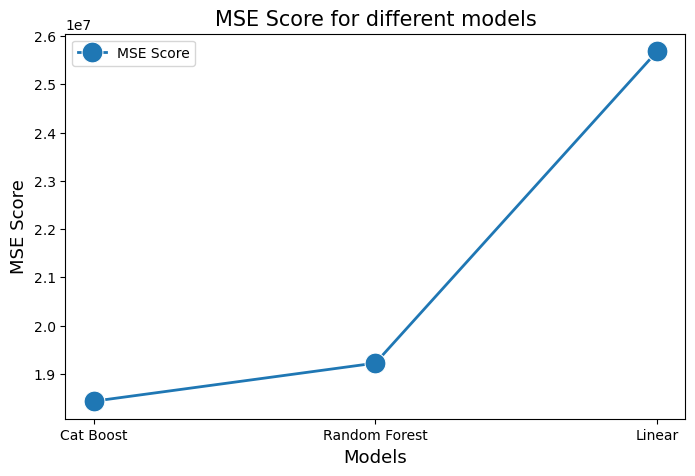

In [56]:
mse=[18432704.389719605,19222477.941225037, 25684211.32584289]
models = ['Cat Boost', 'Random Forest', 'Linear']

plt.figure(figsize=(8,5))
sns.lineplot(x=models, y=mse, marker='o', linewidth=2, label='MSE Score',markersize=15)
plt.title('MSE Score for different models', fontsize=15)
plt.xlabel('Models', fontsize=13)
plt.ylabel('MSE Score', fontsize=13)


Text(0, 0.5, 'RMSE Score')

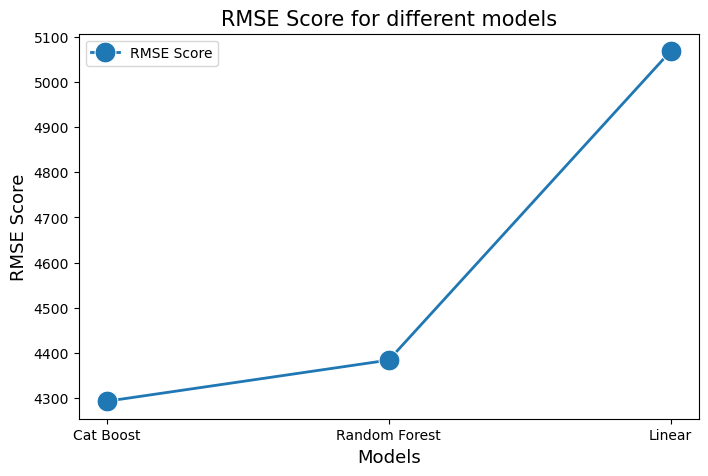

In [57]:
rmse=[4293.332550562512,4384.344642158624,5067.959286127198]
models = ['Cat Boost', 'Random Forest', 'Linear']

plt.figure(figsize=(8,5))
sns.lineplot(x=models, y=rmse, marker='o', linewidth=2, label='RMSE Score',markersize=15)
plt.title('RMSE Score for different models', fontsize=15)
plt.xlabel('Models', fontsize=13)
plt.ylabel('RMSE Score', fontsize=13)

Text(0, 0.5, 'EVS Score')

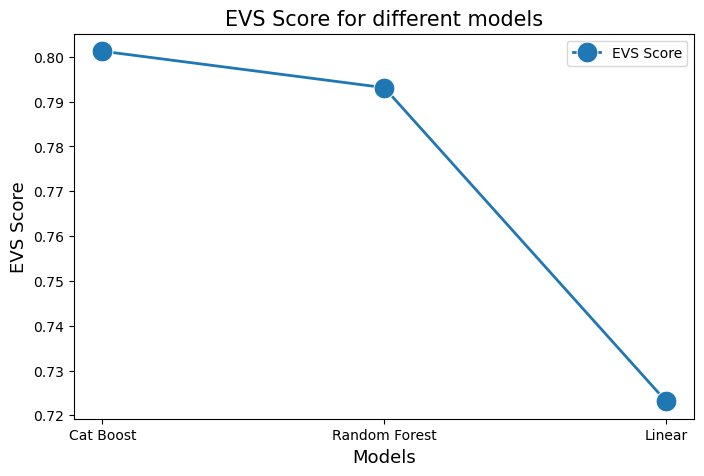

In [58]:
evs_score = [0.8012465927442007, 0.793119430709514 ,0.7231464686871913]
models = ['Cat Boost', 'Random Forest', 'Linear']

plt.figure(figsize=(8,5))
sns.lineplot(x=models, y=evs_score, marker='o', linewidth=2, label='EVS Score',markersize=15)
plt.title('EVS Score for different models', fontsize=15)
plt.xlabel('Models', fontsize=13)
plt.ylabel('EVS Score', fontsize=13)
